In [1]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from fetch_entsoe import fetch_entsoe_data
from n_trim import nordic
from zones import assign_zones

In [2]:
# Path to your solved network
network_path = "base_s_70_elec_.nc"

# Load it
n = pypsa.Network(network_path)

<frozen importlib._bootstrap>:488: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, storage_units, stores


In [7]:
n = nordic(n, drop_h2_batt=True, extra_buses=['GB4 0'])

In [33]:
def nice_plot(
    n,
    snap=None,
    zones_path='bidding_zones.geojson',
    # kontrast-innstillinger
    ac_cmap="turbo",          # høy kontrast: "turbo" eller "cividis"
    dc_color="tab:green",     # None -> behold PyPSA default; ellers f.eks. "tab:green"/"cyan"
    bus_color="black",        # nodefarge (svart for kontrast)
    # skaleringsknapper
    bus_base=0.010, bus_scale=0.010,
    line_scale=5.0, link_scale=2.5,
    title="Network",
    alpha = 0.6
):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import matplotlib as mpl
    from matplotlib import colors
    try:
        import geopandas as gpd
    except Exception:
        gpd = None

    # snapshot
    if snap is None:
        snap = n.snapshots[0]
    elif isinstance(snap, int):
        snap = n.snapshots[snap]

    # --- bus-størrelse + farge ---
    gen  = n.generators_t.p.loc[snap].groupby(n.generators.bus).sum().reindex(n.buses.index, fill_value=0.0)
    load = (n.loads_t.p.loc[snap].groupby(n.loads.bus).sum().reindex(n.buses.index, fill_value=0.0)
            if not n.loads.empty else pd.Series(0.0, index=n.buses.index))
    net  = (gen - load).abs()
    mx   = float(net.max()) or 1.0
    bus_sizes  = bus_base + bus_scale * (net / mx)
    bus_colors = bus_color

    # --- AC-linjer: tykkelse ∝ s_nom, farge = % loading (0–100) med høy kontrast ---
    line_kwargs = {"line_alpha": alpha}
    cmap = mpl.colormaps.get(ac_cmap)
    norm = colors.Normalize(0, 100)
    if not n.lines.empty:
        s_nom = n.lines.s_nom.replace(0, np.nan)
        mxs   = float(s_nom.max()) if s_nom.notna().any() else 1.0
        line_kwargs["line_widths"] = 1 + line_scale * (s_nom / mxs)

        p0 = n.lines_t.p0.loc[snap].abs().reindex(n.lines.index, fill_value=0.0)
        loading_pct = (100 * (p0 / s_nom)).fillna(0.0).clip(0, 200)
        line_kwargs["line_colors"] = loading_pct.map(lambda v: cmap(norm(v)))
    else:
        line_kwargs["line_widths"] = 1

    # --- DC-linker: tykkelse ∝ p_nom, tydelig grønn (eller standard) ---
    link_kwargs = {}
    if not n.links.empty:
        p_nom = n.links.p_nom.replace(0, np.nan)
        mxp   = float(p_nom.max()) if p_nom.notna().any() else 1.0
        link_kwargs["link_widths"] = 1 + link_scale * (p_nom / mxp)
        link_kwargs["link_alpha"]  = 0.2
        if dc_color is not None:
            link_kwargs["link_colors"] = dc_color  # eksplisitt grønn for kontrast

    # --- plot ---
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    if zones_path and gpd is not None:
        try:
            gdf = gpd.read_file(zones_path)
            gdf.plot(ax=ax, edgecolor="#666666", facecolor="none", linewidth=1.0)   # grå kontur
            gdf.plot(ax=ax, facecolor="#DDDDDD", alpha=0.15, linewidth=0)          # lys fyll
        except Exception:
            pass

    n.plot.map(
        ax=ax,
        bus_sizes=bus_sizes, bus_colors=bus_colors,
        **line_kwargs, **link_kwargs
    )

    if "line_colors" in line_kwargs:
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([]); plt.colorbar(sm, ax=ax, shrink=0.7, label="AC line loading [%]")

    ax.set_title(f"{title} @ {snap}")
    plt.show()


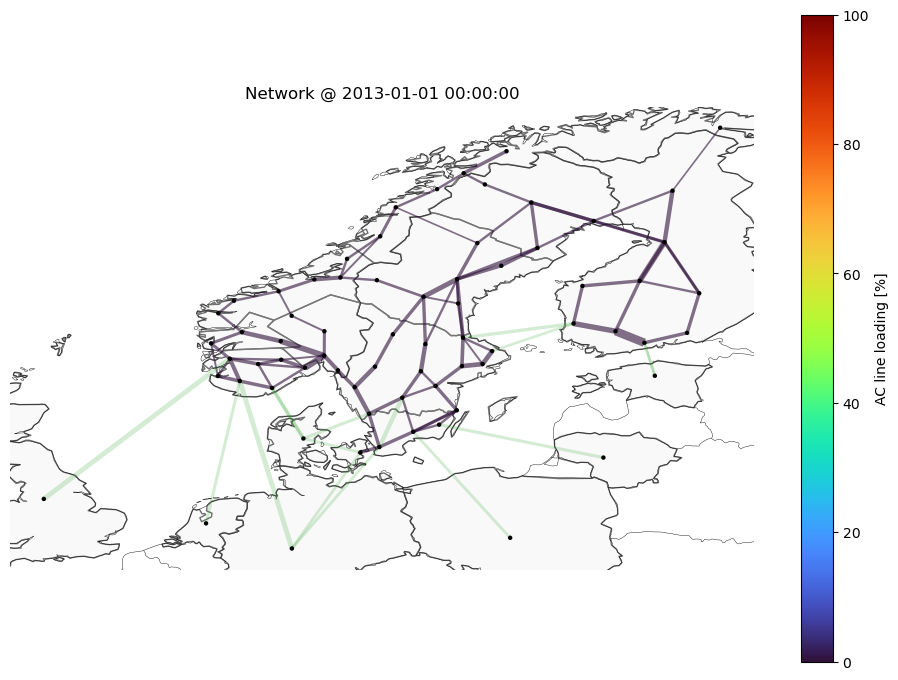

In [34]:
nice_plot(n)

In [9]:
n = assign_zones(sync_n)

In [10]:
n.buses["zone"].value_counts(dropna=False)

zone
SE_3     13
FI        9
NO_2      7
NO_4      6
SE_2      6
NO_3      6
NO_1      4
SE_1      4
NO_5      3
SE_4      3
NL        1
DK_1      1
LT        1
GB        1
PL        1
EE        1
DK_2      1
DE_LU     1
Name: count, dtype: int64

In [11]:
n.generators["zone"].value_counts(dropna=False)

zone
FI       81
SE_3     74
NO_2     34
NO_3     32
SE_2     30
NO_4     25
SE_4     21
NO_5     18
NO_1     18
SE_1     15
DE_LU    13
PL       12
GB       11
LT        9
NL        9
DK_1      9
DK_2      9
EE        7
Name: count, dtype: int64

In [12]:
loads_df, gens_df, flows_df = fetch_entsoe_data(start_date="2025-09-01", timezone="Europe/Oslo")

In [13]:
# ensure tables exist/aligned
n.loads_t.p_set       = n.loads_t.p_set.reindex(index=n.snapshots, columns=n.loads.index, fill_value=0.0)
n.generators_t.p_set  = n.generators_t.p_set.reindex(index=n.snapshots, columns=n.generators.index, fill_value=0.0)

# ---- LOADS: loads_df[zone] -> per-load p_set ----
zone_to_buses = {z: list(i) for z, i in n.buses.groupby("zone").groups.items()}

for z in loads_df.columns:
    buses = zone_to_buses.get(z, [])
    loads = n.loads.index[n.loads.bus.isin(buses)]
    if loads.empty: 
        continue
    series = loads_df[z].reindex(n.snapshots).fillna(0.0) / len(loads)
    for L in loads:
        n.loads_t.p_set[L] = series

# ---- GENERATION: gens_df[(tech, zone)] -> per-generator p_set ----
map_tech = {
    "ccgt":"Fossil Gas","ocgt":"Fossil Gas","biomass":"Biomass",
    "coal":"Fossil Hard coal","lignite":"Fossil Hard coal","oil":"Fossil Oil",
    "nuclear":"Nuclear","onwind":"Wind Onshore",
    "offwind-ac":"Wind Offshore","offwind-dc":"Wind Offshore","offwind-float":"Wind Offshore",
    "solar":"Solar","solar-hsat":"Solar","ror":"Hydro Run-of-river and poundage",
}
gen_tech = n.generators.carrier.astype(str).str.lower().map(map_tech).fillna("Other")

p_set = pd.DataFrame(0.0, index=n.snapshots, columns=n.generators.index)
grp = n.generators.index.to_series().groupby([gen_tech, n.generators["zone"]])

for (T, Z), gens in grp:
    if (T, Z) not in gens_df.columns or len(gens) == 0:
        continue
    s = gens_df[(T, Z)].reindex(n.snapshots).fillna(0.0).to_numpy()[:, None]
    w = n.generators.loc[gens, "p_nom"].to_numpy()
    w = (w / w.sum()) if w.sum() > 0 else np.full(len(gens), 1/len(gens))
    p_set[gens] = s * w

n.generators_t.p_set = p_set

In [14]:
n.lpf(n.snapshots[0])

INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001E22E3C1EB0> for snapshot(s) DatetimeIndex(['2013-01-01'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001E22E460650> for snapshot(s) DatetimeIndex(['2013-01-01'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001E22E4176E0> for snapshot(s) DatetimeIndex(['2013-01-01'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001E22E417800> for snapshot(s) DatetimeIndex(['2013-01-01'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network 

In [32]:
n.generators.columns

Index(['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable',
       'p_nom_min', 'p_nom_max', 'p_min_pu', 'p_max_pu', 'p_set', 'e_sum_min',
       'e_sum_max', 'q_set', 'sign', 'carrier', 'marginal_cost',
       'marginal_cost_quadratic', 'active', 'build_year', 'lifetime',
       'capital_cost', 'efficiency', 'committable', 'start_up_cost',
       'shut_down_cost', 'stand_by_cost', 'min_up_time', 'min_down_time',
       'up_time_before', 'down_time_before', 'ramp_limit_up',
       'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down',
       'weight', 'p_nom_opt', 'zone'],
      dtype='object')

In [19]:
n.buses.control.value_counts()

control
PQ       61
Slack     8
Name: count, dtype: int64